# Tarea 6: Integración con Taylor

Fecha de envío del PR inicial: **viernes 5 de mayo**

Fecha de aceptación del PR: **martes 16 de mayo, antes de la clase**

---

## Ejercicio 1

Usando su implementación de polinomios de Taylor, escriban un integrador para la ecuación diferencial que se desarrolló en este ejemplo, esto es, $\dot{x} = x^2$ con la condición inicial $x(0) = 3$. 

El integrador debe hacer las operaciones necesarias para obtener automáticamente los coeficientes $x_{[k]}$, *en cada paso de integración*, a partir de la condición inicial local. Un requisito básico para esto es que tengan una implementación de la función $P_\alpha(x) = [g(x)]^\alpha$ con $g(x)$ un polinomio de Taylor, que hicieron en la "Tarea5", y que funcione bien en particular para `alpha::Int`.

La implementación debe consistir de varias funciones: 

1. Una función donde se calculen los coeficientes $x_{[k]}$ de la expansión. Esta función deberá llamar a otra donde se implementan las recurrencias que imponen las ecuaciones de movimiento.

2. Una función donde se obtenga el paso de integración $h$ como se describió en el notebook 10.

- Otra función donde se haga la suma usando el método de Horner.

- Finalmente, una función que combine las funciones anteriores para hacer la integración desde un tiempo inicial a uno final. En este punto, *fingiremos ignorancia*, en el sentido de  que el tiempo inicial es cero, y el tiempo final será $0.5$ (que está más allá de donde la solución está definida).


Dado que conocemos la solución analítica de este problema, grafiquen como función de $t$ el error relativo de su integrador (respecto al valor del resultado analítico).

In [1]:
include("Taylor.jl")
using ADT
using PyPlot

1. Utilizando que 

\begin{equation}
x_{[k]} = \frac{f_{[k-1]}}{k},
\end{equation}
   podemos definir una funcion que encuentre de manera iterativa los coeficientes de $x(t)$

In [2]:
function coeficient(x0::Number, f::Function, n = 30)
    ## n fue escogido de manera arbitraria, 30 parece un buen numero
    a = [x0]
    
    for k = 1:(n - 1) ## usar n - 1 nos deja con un polinomio de grado n ya que se utiliza el valor de x0
        iter = f(Taylor(a))
        push!(a, iter.coef[k]/(k))
    end
    
    return Taylor(a)
end

coeficient (generic function with 2 methods)

In [3]:
x_t = coeficient(3.0, x -> x^2)

ADT.Taylor{Float64}([3.0,9.0,27.0,81.0,243.0,729.0,2187.0,6561.0,19683.0,59049.0  …  1.04604e10,3.13811e10,9.41432e10,2.8243e11,8.47289e11,2.54187e12,7.6256e12,2.28768e13,6.86304e13,2.05891e14])

Como vemos la solucion cumple con lo obtenido analiticamente, esto es
$x_0 = 3^1$, $x_1 = 3^2$, $x_2 = 3^3$, ... , $x_n = 3^{n+1}$, 

Ahora necesitamos una funcion que determine el paso de integracion adaptativo

Utilizamos

\begin{equation}
h = t-t_0 \leq \Big(\frac{\epsilon}{\big| x_{[p]}(t_0)\big|}\Big)^{1/p}.
\end{equation}

Condicion que brinda la convergencia de la serie de potencia $p$

In [4]:
function adaptive_step(a::Taylor, epsi = 1e-30)
    p = gradomax(a)
    while p != 0 && a.coef[p] == 0 ## Asi utilizamos el ultimo termino no nulo
        p -= 1
    end
    h = 0.5 * (epsi / abs(a.coef[p]))^(1/p) ## Multiplicar por 0.5 nos garantiza que es menor que la cota
    return h
end

adaptive_step (generic function with 2 methods)

In [5]:
adaptive_step(x_t)

0.016666666666666666

Ahora definimos una funcion que utilice el metodo de Horner para valuar el polinomio.

In [6]:
function horner_evaluation(a::Taylor, x0::Number)
    n = gradomax(a)
    y = a.coef[n]
    
    for i = 1:(n - 1)
        y = a.coef[n - i] + y * x0
    end
    
    return y
end

horner_evaluation (generic function with 1 method)

Por ultimo definimos una funcion que combina las funciones anteriores de manera que haga la integracion de un tiempo $t_0$ a un $t_f$

In [7]:
function integradorT(f::Function, t0::Number, tf::Number, x0::Number)
    
    max = 1000 ## Iteraciones maximas del while
    
    tiempos = [t0]
    solucion = [x0]
    
    n = 0 ## Contador

    while t0 < tf && isnan(x0) == false && n < max  ## el isnan() nos ayuda a parar la integracion al pasar por nu punto singular
        
        sol = coeficient(x0, f)
        h = adaptive_step(sol)
        
        t0 += h
        
        x0 = horner_evaluation(sol, h)
        
        push!(tiempos, t0)
        push!(solucion, x0)
        n += 1
        
    end
    
    return tiempos, solucion
end

integradorT (generic function with 1 method)

Probamos el integrador con el ejemplo

In [8]:
ẋ(x) = x^2
f(x) = 3.0 / (1.0 - 3.0 * x) ## Solucion analitica

f (generic function with 1 method)

In [9]:
t_1, y = integradorT(ẋ, 0.0, 0.5, 3.0)
F_T = map(f, t_1);

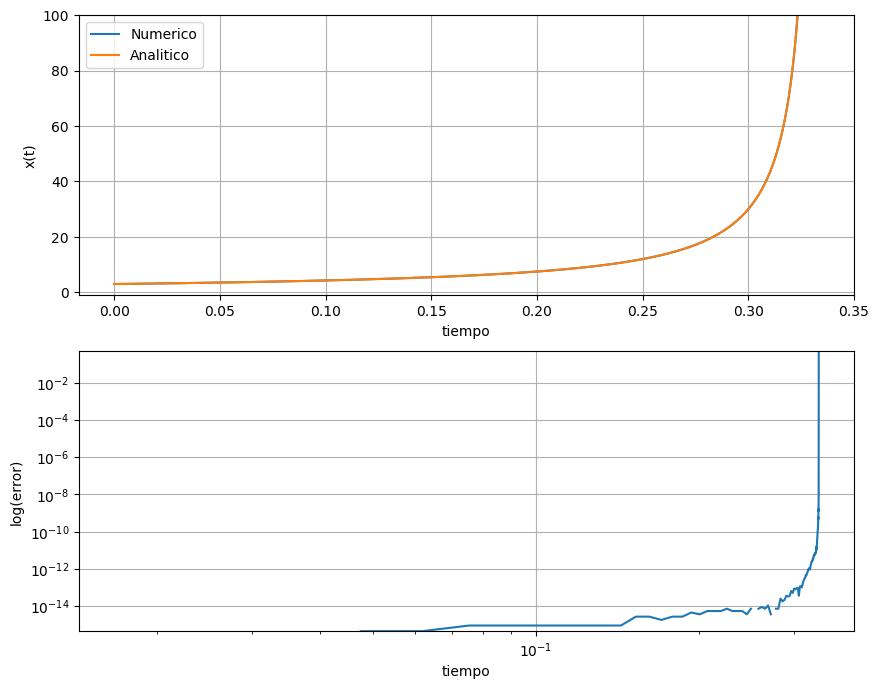

PyObject <matplotlib.text.Text object at 0x7fa6c1fad278>

In [10]:
fig = figure(figsize = (10, 8))

ax = subplot(211); bx = subplot(212)

ax[:plot](t_1, y, label  = "Numerico")
ax[:plot](t_1, map(f, t_1), label = "Analitico")
ax[:set_ylim](-1, 100)

err_T = abs(F_T - y)
bx[:loglog](t_1, err_T)
bx[:grid]()
bx[:set_ylim](0, 0.5)

ax[:legend](); ax[:grid]()
ax[:set_xlabel]("tiempo"); ax[:set_ylabel]("x(t)")
bx[:set_xlabel]("tiempo"); bx[:set_ylabel]("log(error)")

Podemos ver que el error en el calculo se vuelve grande al acercarnos a la singularidad en $t = \frac{1}{3}$

---

## Ejercicio 2

Repitan la integración del ejercicio anterior usando el método de Runge-Kutta de 4o orden con paso de integración fijo (que es lo más sofisticado que conocen hasta ahora) y comparen los resultados del error relativo con los obtenidos con el método de Taylor. En particular, finjan ignorancia de la misma manera que en el ejercicio anterior.

Comenzamos por definir el integrador de Runge-Kutta

In [11]:
function RK4(f::Function, x0::Real, t0::Real, h::Real, p::Integer)

    x = zeros(typeof(promote(x0,1.5)[1]),p+1) #inicializar el array solución con el mayor sobre tipo común al de x_0 y Float64 

    x[1] = x0
    t = t0
    
    for i in 1:p
        
        k1 = f(t, x[i])
        k2 = f(t + h / 2, x[i] + h * k1 / 2)
        k3 = f(t + h / 2, x[i] + h * k2 / 2)
        k4 = f(t + h, x[i] + h * k3)
         
        x[i + 1] = x[i] + (h / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
        
        t += h
    end
    
    return x
end

RK4 (generic function with 1 method)

In [12]:
k(t,x)=x^2

k (generic function with 1 method)

In [13]:
x0 = 3.0
t0 = 0
tf = 0.5
p  = 5000

h = (tf - t0) / p

x = RK4(k, x0, t0, h, p)
t_2 = linspace(t0, tf, length(x))
F_RK4 = map(f, t_2)
err_RK4 = abs(F_RK4 - x);

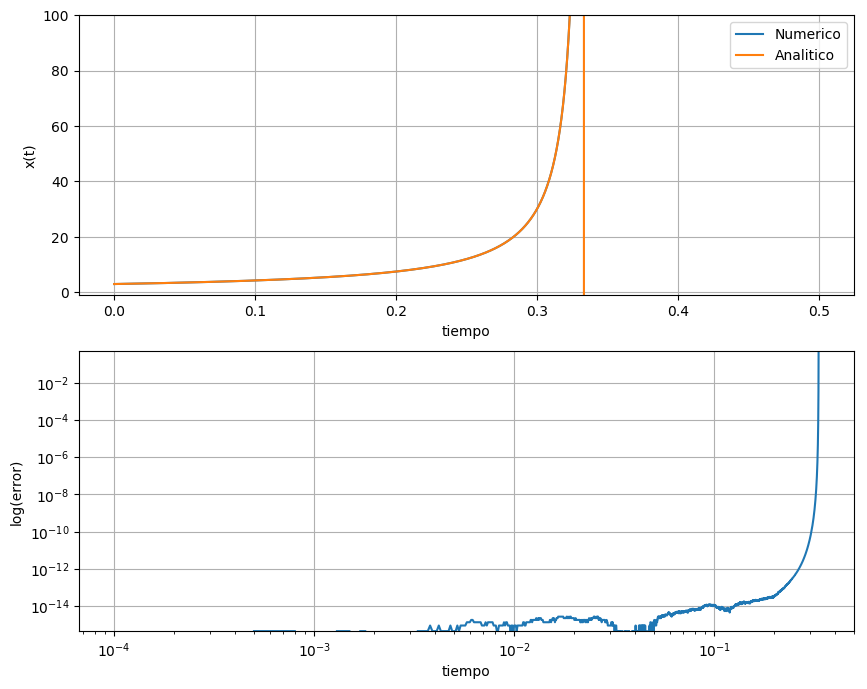

PyObject <matplotlib.text.Text object at 0x7fa6bf1a2f28>

In [14]:
fig = figure(figsize = (10, 8))

ax = subplot(211); bx = subplot(212)

ax[:plot](t_2, x, label  = "Numerico")
ax[:plot](t_2, map(f, t_2), label = "Analitico")
ax[:set_ylim](-1, 100)


bx[:loglog](t_2, err_RK4)
bx[:grid]()
bx[:set_ylim](0, 0.5)

ax[:legend](); ax[:grid]()
ax[:set_xlabel]("tiempo"); ax[:set_ylabel]("x(t)")
bx[:set_xlabel]("tiempo"); bx[:set_ylabel]("log(error)")

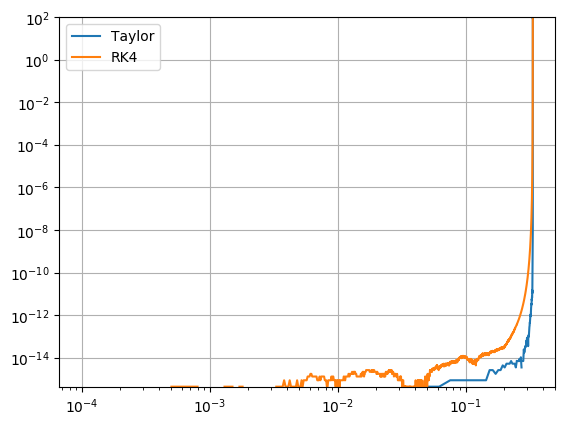

PyObject <matplotlib.legend.Legend object at 0x7fa6bef60198>

In [15]:
loglog(t_1, err_T, label = "Taylor")
loglog(t_2, err_RK4, label = "RK4")
ylim(0, 100)
grid()
legend()

Podemos ver que el integrador de Taylor tiene una mejor convergencia que RK4

---

## Ejercicio 3

Integra la ecuación de movimiento para el oscilador armónico, $\ddot{x} = -2x$, con $x(0)=2$, $\dot{x}(0)=0$, durante 10^4 periodos de oscilación (o sea, hasta $t_f = 10^4 \cdot 2\pi/\sqrt{2}$, usando el método de Taylor y el método de Runge-Kutta de 4o orden con paso de integración constante. Compara cómo cambia la energía (respecto al valor al tiempo cero) en función del tiempo en ambos métodos.

Para resolver el sistema podemos hacer el siguiente cambio de variable


\begin{eqnarray}
\dot{x} & = &  y\\
\dot{y} & = & -2x
\end{eqnarray}

y utilizamos las condiciones iniciales $x(0) = 2$ y $y(0) = 0$

Necesitamos una funcion que realize de manera automatica y simultanea el calculo de los coeficientes

In [16]:
function coeficient2(x0::Number, y0::Number, f::Function, n = 30)
    ## n fue escogido de manera arbitraria, 30 parece un buen numero
    X = [x0]
    Y = [y0]

    for k = 1:(n - 1) ## usar n - 1 nos deja con un polinomio de grado n ya que se utiliza el valor de x0
        iter = f(Taylor(X))

        push!(Y, iter.coef[k]/(k))
        push!(X, Y[k]/(k))

    end
    
    return Taylor(X), Taylor(Y)
end

coeficient2 (generic function with 2 methods)

In [17]:
function integradorT2(f::Function, t0::Number, tf::Number, x0::Number, y0::Number)
    
    max = 1000 ## Iteraciones maximas del while
    
    tiempos = [t0]
    X = [x0]
    Y = [y0]
    
    n = 0 ## Contador

    while t0 < tf && isnan(x0) == false && n < max  ## el isnan() nos ayuda a parar la integracion al pasar por nu punto singular
        
        solX, solY = coeficient2(x0, y0, f)
        hx = adaptive_step(solX)
        hy = adaptive_step(solY)
          
        h = min(hx, hy)
        
        t0 += h
        
        x0 = horner_evaluation(solX, h)
        y0 = horner_evaluation(solY, h)

        push!(tiempos, t0)
        push!(X, x0)
        push!(Y, y0)

        n += 1
        
    end
    
    return tiempos, X, Y
end

integradorT2 (generic function with 1 method)

Necesitamos un integrador de RK4 para el sistema

In [18]:
function RK4_2(f::Function, g::Function, x0::Real, y0::Real, t0::Real, h::Real, p::Integer)
   
    x = zeros(typeof(promote(x0,1.5)[1]), p + 1) #inicializar el array solución con el mayor sobre tipo común al de x_0 y Float64 
    y = zeros(typeof(promote(y0,1.5)[1]), p + 1)
    
    x[1] = x0
    y[1] = y0
    
    t = t0
    
    for i in 1:p
        
        k1 = f(t, x[i], y[i])
        l1 = g(t, x[i], y[i])
        k2 = f(t + h / 2, x[i] + h * k1 / 2, y[i] + h *l1 / 2)
        l2 = g(t + h / 2, x[i] + h * k1 / 2, y[i] + h *l1 / 2)
        k3 = f(t + h / 2, x[i] + h * k2 / 2, y[i] + h *l2 / 2)
        l3 = g(t + h / 2, x[i] + h * k2 / 2, y[i] + h *l2 / 2)
        k4 = f(t + h, x[i] + h * k3, y[i] + h * l3)
        l4 = g(t + h, x[i] + h * k3, y[i] + h * l3)
         
        x[i + 1] = x[i] + (h / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
        y[i + 1] = y[i] + (h / 6) * (l1 + 2 * l2 + 2 * l3 + l4)
        
        t += h
    end
    return x, y
end

RK4_2 (generic function with 1 method)

Por ultimo, necesitamos una funcion que nos de la energia del sistema, dada por 

$$ E = \frac{1}{2} y^2 + x^2$$

Utilizando las condiciones iniciales tenemos

$$ E_0 = \frac{1}{2}(y(0))^2 + (x(0))^2$$
$$ E_0 = \frac{1}{2}(0)^2 + (2)^2 = 4$$

In [19]:
E(x, y) = 0.5 * (y ^ 2) + x ^ 2
Ẋ(t, x, y) = y
Ẏ(t, x, y) = - 2 * x

Ẏ (generic function with 1 method)

In [20]:
x0 = 2.0
y0 = 0.0
t0 = 0.0
tf = 10^4 * (2 * pi / sqrt(2))
p = 10000

h = (tf - t0) / p

T1, X1, Y1 = integradorT2(x -> - 2 * x, t0, tf, x0, y0)
E_T = E.(X1, Y1);

X2, Y2 = RK4_2(Ẋ, Ẏ , x0, y0, t0, h, p)
T2 = linspace(t0, tf, length(X1))
E_RK4 = E.(X2, Y2);

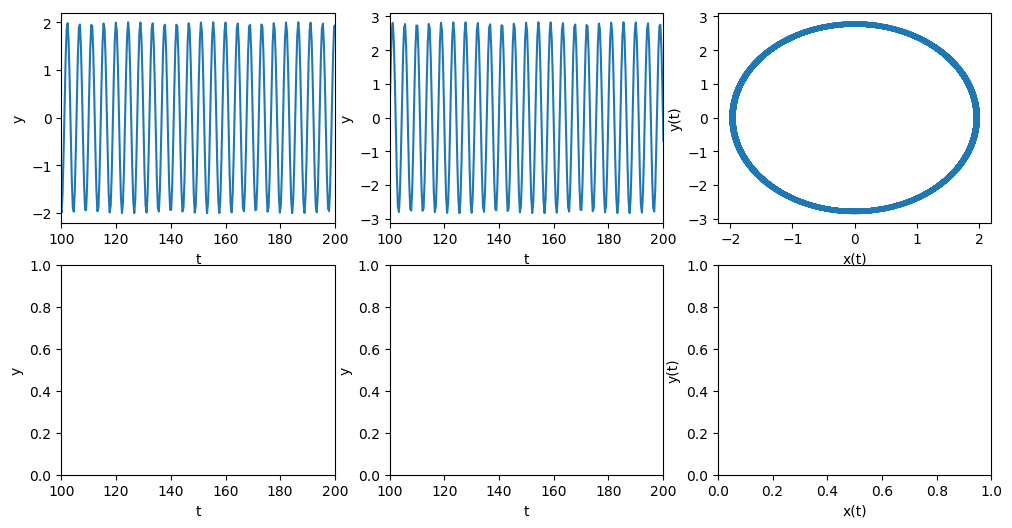

PyObject <matplotlib.text.Text object at 0x7fa6bb1a3390>

In [23]:
fig1 = figure(figsize = (12, 6))

ax = subplot(231)
bx = subplot(232)
cx = subplot(233)
dx = subplot(234)
ex = subplot(235)
fx = subplot(236)


ax[:plot](T1, X1); bx[:plot](T1, Y1); cx[:plot](X1, Y1)
# dx[:plot](T2, X2); ex[:plot](T2, Y2); fx[:plot](X2, Y2)

ax[:set_xlim](100, 200); bx[:set_xlim](100, 200);
dx[:set_xlim](100, 200); ex[:set_xlim](100, 200);

ax[:set_xlabel]("t"); bx[:set_xlabel]("t"); cx[:set_xlabel]("x(t)")
dx[:set_xlabel]("t"); ex[:set_xlabel]("t"); fx[:set_xlabel]("x(t)")

ax[:set_ylabel]("y"); bx[:set_ylabel]("y"); cx[:set_ylabel]("y(t)")
dx[:set_ylabel]("y"); ex[:set_ylabel]("y"); fx[:set_ylabel]("y(t)")

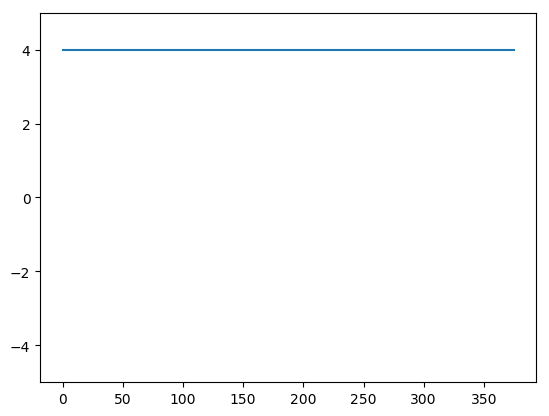

(-5,5)

In [24]:
plot(T1, E_T)
ylim(-5, 5)
# plot(T2, E_RK4)